# Reinforcement Learning for Recommender Systems
## From Contextual Bandits to Slate-Q

<table>
<tr>
    <td> <img src="images/youtube.png" style="width: 230px;"/> </td>
    <td> <img src="images/dota2.jpg" style="width: 213px;"/> </td>
    <td> <img src="images/forklifts.jpg" style="width: 169px;"/> </td>
    <td> <img src="images/spotify.jpg" style="width: 254px;"/> </td>
    <td> <img src="images/robots.jpg" style="width: 252px;"/> </td>
</tr>
</table>


### Overview
“Industry-grade, hands-on RL with Ray RLlib” is a tutorial for industry researchers, domain-experts, and ML-engineers, showcasing ...

1) .. how you can use RLlib to build a recommender system simulator for your industry applications and run a slate-capable algorithm against this simulator.

2) .. how RLlib's offline algorithms pose solutions in case you don't have a simulator of your problem environment at hand.

We will further explore how to deploy one or more trained models to production using Ray Serve and how RLlib's bandit algorithms could be used to select the best model from some set of candidates for that purpose.

During the live-coding phases, we will build a recommender system simulating environment with RLlib and google's RecSim, choose, configure, and run an RLlib algorithm, and experiment and tune hyperparameters with Ray Tune.

RLlib offers industry-grade scalability, a large list of algos to choose from (offline, model-based, model-free, etc..), support for TensorFlow and PyTorch, and a unified API for a variety of applications. This tutorial includes a brief introduction to provide an overview of concepts (e.g. why RL?) before proceeding to RLlib (recommender system) environments, neural network models, offline RL, student exercises, Q/A, and more. All code will be provided as .py files in a GitHub repo.

### Intended Audience
* Python programmers who are interested in using RL to solve their specific industry decision making problems and who want to get started with RLlib.

### Prerequisites
* Some Python programming experience.
* Some familiarity with machine learning.
* *Helpful, but not required:* Experience in reinforcement learning and Ray.
* *Helpful, but not required:* Experience with TensorFlow or PyTorch.

### Requirements/Dependencies

To get this very notebook up and running on your local machine, you can follow these steps here:

Install conda (https://www.anaconda.com/products/individual)

Then ...

#### Quick `conda` setup instructions (Linux):
```
$ conda create -n rllib_tutorial python=3.9
$ conda activate rllib_tutorial
$ pip install "ray[rllib,serve]" recsim jupyterlab tensorflow torch
```

#### Quick `conda` setup instructions (Mac):
```
$ conda create -n rllib_tutorial python=3.9
$ conda activate rllib_tutorial
$ pip install cmake "ray[rllib,serve]" recsim jupyterlab tensorflow torch
$ pip install grpcio # <- extra install only on apple M1 mac
```

#### Quick `conda` setup instructions (Win10):
```
$ conda create -n rllib_tutorial python=3.9
$ conda activate rllib_tutorial
$ pip install "ray[rllib,serve]" recsim jupyterlab tensorflow torch
$ pip install pywin32 # <- extra install only on Win10.
```

### Opening these tutorial files:
```
$ git clone https://github.com/sven1977/rllib_tutorials
$ cd rllib_tutorials/rl_conference_2022
$ jupyter-lab
```


### Key Takeaways
* What is reinforcement learning and RLlib?
* How do recommender systems work? How do we build our own?
* How do we train RLlib's different algorithms on a recommender system problem?
* (Optional) What's offline RL and how can I use it with RLlib?



### TODO: Tutorial Outline

1. RL in a nutshell. How to formulate any problem as an RL-solvable one?
1. Recommender systems - How they work

(7min break)

1. What are contextual bandits?
1. How to use contextual Bandits with RLlib and start our first training run.
1. What if the environment becomes more difficult? Intro to google's RecSim and RLlib's Slate-Q algorithm.
1. Starting a Slate-Q training run using Ray Tune.

(7min break)

1. Intro to Offline RL.
1. What if we don't have an environment? Pretending the output of our previous experiments is historic data with which we can train an offline RL agent.
1. BC and MARWIL: Quick how-to and setup instructions.
1. Off policy evaluation (OPE) as a means to estimate how well an offline-RL trained policy will perform in production.
1. Ray Serve example: How can we deploy a trained policy into our production environment?


### Other Recommended Readings
* [Reinforcement Learning with RLlib in the Unity Game Engine](https://medium.com/distributed-computing-with-ray/reinforcement-learning-with-rllib-in-the-unity-game-engine-1a98080a7c0d)

<img src="images/unity3d_blog_post.png" width=400>

* [Attention Nets and More with RLlib's Trajectory View API](https://medium.com/distributed-computing-with-ray/attention-nets-and-more-with-rllibs-trajectory-view-api-d326339a6e65)
* [Intro to RLlib: Example Environments](https://medium.com/distributed-computing-with-ray/intro-to-rllib-example-environments-3a113f532c70)

# Let's start!

In [ ]:
# Let's get started with some basic imports.

import ray  # .. of course

import gym
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
from pprint import pprint
import re
import recsim  # google's recsim package.
import requests
from scipy.interpolate import make_interp_spline, BSpline
from scipy.stats import sem  # standard error of the mean
import tree  # dm_tree

## Introducing google RecSim

<img src="images/recsim_documentation.png" width=600 style="float:right;">

<a href="https://github.com/google-research/recsim">Google's RecSim package</a> offers a flexible way for you to <a href="https://github.com/google-research/recsim/blob/master/recsim/colab/RecSim_Developing_an_Environment.ipynb">define the different building blocks of a recommender system</a>:


- User model (how do users change their preferences when having been faced with, selected, and consumed certain items?).
- Document model: Features of documents and how do documents get pre-selected/sampled.
- Reward functions.

RLlib comes with 3 off-the-shelf RecSim environments that are ready for training (with RLlib):
* Long Term Satisfaction (<- our first environment)
* Interest Evolution (<- harder env, we'll work with later on)
* Interest Exploration (<- not used today)

In [402]:
# Import a built-in RecSim environment, ready to be trained by RLlib.
from ray.rllib.examples.env.recommender_system_envs_with_recsim import LongTermSatisfactionRecSimEnv

# Create a RecSim instance using the following config parameters (very similar to what we used above in our own recommender system env):
lts_10_env = LongTermSatisfactionRecSimEnv({
    "num_candidates": 10,
    "slate_size": 1,
    "resample_documents": False,  # Set to False for re-using the same candidate doecuments each timestep.
})
# Start a new episode and look at initial observation.
obs = lts_10_env.reset()
pprint(obs)

OrderedDict([('user', array([], dtype=float32)),
             ('doc',
              {'0': array([0.5488135], dtype=float32),
               '1': array([0.71518934], dtype=float32),
               '2': array([0.60276335], dtype=float32),
               '3': array([0.5448832], dtype=float32),
               '4': array([0.4236548], dtype=float32),
               '5': array([0.6458941], dtype=float32),
               '6': array([0.4375872], dtype=float32),
               '7': array([0.891773], dtype=float32),
               '8': array([0.96366274], dtype=float32),
               '9': array([0.3834415], dtype=float32)}),
             ('response',
              (OrderedDict([('click', 0),
                            ('engagement',
                             array(21.269724, dtype=float32))]),))])


In [373]:
# Let's send our first action (k-slate back into the env).

# What was our action space again?
lts_10_env.action_space
#action = np.array([5])
#print(action)

MultiDiscrete([10])

In [409]:
#user-satisfacton={lts_10_env.env.env.env._environment._user_model._user_state.satisfaction}
action = np.array([9])
next_obs, reward, done, _ = lts_10_env.step(action)
pprint(next_obs)
print(f"reward = {reward:.2f}; done = {done}")

OrderedDict([('user', array([], dtype=float32)),
             ('doc',
              {'0': array([0.5488135], dtype=float32),
               '1': array([0.71518934], dtype=float32),
               '2': array([0.60276335], dtype=float32),
               '3': array([0.5448832], dtype=float32),
               '4': array([0.4236548], dtype=float32),
               '5': array([0.6458941], dtype=float32),
               '6': array([0.4375872], dtype=float32),
               '7': array([0.891773], dtype=float32),
               '8': array([0.96366274], dtype=float32),
               '9': array([0.3834415], dtype=float32)}),
             ('response',
              ({'click': 1, 'engagement': array(19.73187, dtype=float32)},))])
reward = 19.73; done = False


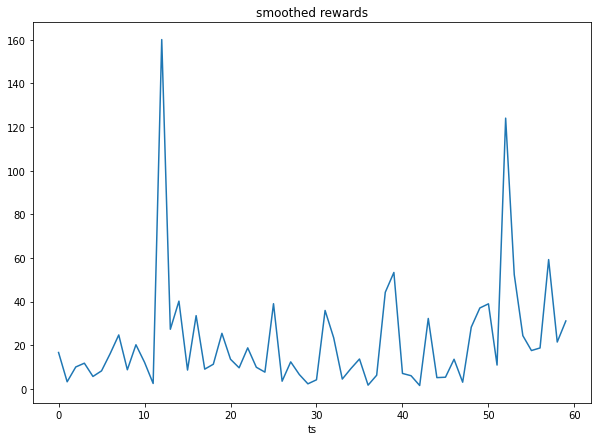

In [440]:
obs = lts_10_env.reset()
action_high = np.array([np.argmax([value for _, value in obs["doc"].items()])])
action_low = np.array([np.argmin([value for _, value in obs["doc"].items()])])

done = False
rewards = []
satisfactions = []
while not done:
    obs, reward, done, _ = lts_10_env.step(action_high) #np.random.choice([action_low, action_high])]))
    rewards.append(reward)
    satisfactions.append(lts_10_env.env.env.env._environment._user_model._user_state.satisfaction)

plt.figure(figsize=(10,7))
plt.plot([np.mean(rewards[i:i+1]) for i in range(len(x))])  # [np.mean([r[max(i-10, 0):i] for r in all_rewards]) for i in range(20, len(x))]
#plt.plot((np.array(satisfactions) - 0.5) * 10000)
plt.title("smoothed rewards")
plt.xlabel("ts")
plt.show()

#### What have we learnt from experimenting with the environment?

* Episodes seem to last at least n timesteps (user seems to have some time budget to spend).
* User always seems to click, no matter what we recommend.
* Reward seems to be always identical to the "engagement" value (of the clicked item).
* Weak suspicion: If we always recommend the item with the highest feature value, rewards seem to taper off over time - in most of the episodes.
* Weak suspicion: If we always recommend the item with the lowest feature value, rewards seem to increase over time.

### What the environment actually does under the hood

Let's take a quick look at a pre-configured RecSim environment: "Long Term Satisfaction".

<img src="images/long_term_satisfaction_env.png">

## Measuring random baseline of our environment

In the cells above, we created a new environment instance (`lts_10_env`). As we have seen above, in order to start "walking" through a recommender system episode, we need to perform `reset()` and then several `step()` calls (with different actions) until the returned `done` flag is True.


In [ ]:
def test_env(env, episodes=1000, verbose=False):

    # 1) Reset the env.
    obs = env.reset()

    # Number of episodes already done.
    num_episodes = 0
    # Current episode's accumulated reward.
    episode_reward = 0.0
    # Collect all episode rewards here to be able to calculate a random baseline reward.
    episode_rewards = []

    # 2) Enter an infinite while loop (to step through the episode).
    while num_episodes < episodes:
        # 3) Calculate agent's action, using random sampling via the environment's action space.
        action = env.action_space.sample()
        # action = trainer.compute_single_action([obs])

        # 4) Send the action to the env's `step()` method to receive: obs, reward, done, and info.
        obs, reward, done, info = env.step(action)
        episode_reward += reward

        # 5) Check, whether the episde is done, if yes, break out of the while loop.
        if done:
            if verbose:
                print(f"Episode done - accumulated reward={episode_reward}")
            elif num_episodes % 100 == 0:
                print(f" {num_episodes} ", end="")
            elif num_episodes % 10 == 0:
                print(".", end="")
            num_episodes += 1
            env.reset()
            episode_rewards.append(episode_reward)
            episode_reward = 0.0

    # 6) Print out mean episode reward!
    env_mean_random_reward = np.mean(episode_rewards)
    print(f"\n\nMean episode reward when acting randomly: {env_mean_random_reward:.2f}+/-{sem(episode_rewards):.2f}")

    return env_mean_random_reward, sem(episode_rewards)

lts_10_env_mean_random_reward, lts_10_env_sem_random_reward = test_env(lts_10_env, episodes=500)


In [ ]:
# Let's create a somewhat tougher version of this with 50 candidates (instead of 10).
lts_50_env = LongTermSatisfactionRecSimEnv(config={
    "num_candidates": 50,
    "slate_size": 1,
    "resample_documents": True,
})

lts_50_env_mean_random_reward, lts_50_env_sem_random_reward = test_env(lts_50_env, episodes=500)


------------------
## 7 min break :)
------------------

# Plugging in RLlib


In [ ]:
# Start a new instance of Ray (when running this tutorial locally) or
# connect to an already running one (when running this tutorial through Anyscale).

ray.init()  # Hear the engine humming? ;)

# In case you encounter the following error during our tutorial: `RuntimeError: Maybe you called ray.init twice by accident?`
# Try: `ray.shutdown() + ray.init()` or `ray.init(ignore_reinit_error=True)`

## Picking an RLlib algorithm ("Trainer")

https://docs.ray.io/en/master/rllib-algorithms.html#available-algorithms-overview

<img src="images/rllib_algorithms.png">

### What's a Bandit?
<img src="images/simple_n_armed_bandit.png" width=800>

In [ ]:
# In order to use one of the above algorithms, you may instantiate its associated Trainer class.
# For example, to import a Bandit Trainer (w/ Upper Confidence Bound exploration), do:

from ray.rllib.agents.bandit import BanditLinUCBTrainer

### Trying a contextual Bandit on our environment
<img src="images/contextual_bandit.png" width=800>

In [ ]:
bandit_config = {
    "env": LongTermSatisfactionRecSimEnv,
    "env_config": {
        "num_candidates": 50,  # 50x49 ~2500 unique slates (arms)
        "slate_size": 2,
        # Bandit-specific flags:
        "convert_to_discrete_action_space": True,
        # Convert "doc" key into "item" key.
        "wrap_for_bandits": True,
    },
    # Generate a result dict every single time step.
    "timesteps_per_iteration": 1,
}

# Create the RLlib Trainer using above config.
bandit_trainer = BanditLinUCBTrainer(config=bandit_config)
bandit_trainer

#### Running a single training iteration, by calling the `.train()` method:

One iteration for most algos involves:

1. Sampling from the environment(s)
1. Using the sampled data (observations, actions taken, rewards) to update the policy model (e.g. a neural network), such that it would pick better actions in the future, leading to higher rewards.

Let's try it out:

In [ ]:
# Perform single `.train()` call.
result = bandit_trainer.train()
# Erase config dict from result (for better overview).
del result["config"]
# Print out training iteration results.
pprint(result)

In [ ]:
# Train for n more iterations (timesteps) and collect n-arm rewards.
rewards = []
for i in range(2000):
    result = bandit_trainer.train()
    rewards.append(result["episode_reward_mean"])
    if i % 500 == 0:
        print(f" {i} ", end="")
    elif i % 100 == 0:
        print(".", end="")

# Plot per-timestep (episode) rewards.
plt.figure(figsize=(10,7))
start_at = 0
smoothing_win = 50
x = list(range(start_at, len(rewards)))
y = [np.nanmean(rewards[max(i - smoothing_win, 0):i]) for i in range(start_at, len(rewards))]
plt.plot(x, y)
plt.title("Mean reward")
plt.xlabel("Time/Training steps")

# Add mean random baseline reward (red line).
plt.axhline(y=lts_50_env_mean_random_reward, color="r", linestyle="-")

plt.show()

## Trying Bandits on a tougher environment

So far, we have trained a UCB Bandit against the LongTermSatisfaction environment, a quite simple problem to solve.

Let's move to a more complex RecSim environmeent: The InterestEvolution env.

<img src="images/interest_evolution_env.png">

In [ ]:
from ray.rllib.examples.env.recommender_system_envs_with_recsim import InterestEvolutionRecSimEnv

# Update our env: Making things harder.
# Leave the env_config the same as for the
# LongTermEvolution env: 50 candidates, slate-size=2
bandit_config.update({
    "env": InterestEvolutionRecSimEnv,
    "env_config": dict(bandit_config["env_config"], **{
        "num_candidates": 50,  # 50*49= ~2500 unique slates
        "slate_size": 2,  # k=2
    }),
})

interest_evolution_env_for_bandits = InterestEvolutionRecSimEnv(config=bandit_config["env_config"])

# Re-computing our random baseline.
harder_env_mean_random_reward, _ = test_env(interest_evolution_env_for_bandits, episodes=200)

# Create the RLlib Trainer using above config.
bandit_trainer = BanditLinUCBTrainer(config=bandit_config)

# Train for n iterations (timesteps) and collect n-arm rewards.
rewards = []
for i in range(3000):
    result = bandit_trainer.train()
    rewards.append(result["episode_reward_mean"])
    if i % 500 == 0:
        print(f" {i} ", end="")
    elif i % 100 == 0:
        print(".", end="")

# Plot per-timestep (episode) rewards.
plt.figure(figsize=(10,7))
start_at = 100
smoothing_win = 500
x = list(range(start_at, len(rewards)))
y = [np.nanmean(rewards[max(i - smoothing_win, 0):i]) for i in range(start_at, len(rewards))]
plt.plot(x, y)
plt.title("Mean reward")
plt.xlabel("Time/Training steps")

# Add mean random baseline reward (red line).
plt.axhline(y=harder_env_mean_random_reward, color="r", linestyle="-")

plt.show()

In [ ]:
results = tune.run("BanditLinUCB", config=bandit_config, stop={"timesteps_total": 3000}, verbose=1, num_samples=10)

#### Well, that doesn't look so great anymore.

Bandits are able to learn recommender-system envs, but are having a harder time when we increase the number of candidates to select from, the number of users, the slate size, and the episode/session length.

<img src="images/rewards_bandit_on_50_2_ie_env.png">

Luckily, RLlib offers another algorithm - Slate-Q - designed for k-slate and long-time horizon (user journey) recommendation problems.

### Switching to Slate-Q
<img src="images/slateq.png" width=800>

In [ ]:
# Import a Trainable (one of RLlib's built-in algorithms):
# We use the SlateQ algorithm here b/c it is specialized in solving slate recommendation problems
# and works well with RLlib's RecSim environment adapter.

from ray.rllib.agents.slateq import SlateQTrainer
from ray.rllib.examples.env.recommender_system_envs_with_recsim import InterestEvolutionRecSimEnv


slateq_config = {
    "env": InterestEvolutionRecSimEnv,
    # Use exact same env config as above for direct comparison ...
    "env_config": dict(bandit_config["env_config"],
                       # ... but switch off bandit wrapping and use MultiDiscrete (slate) action space.
                       **{
                            "wrap_for_bandits": False,  # SlateQ != Bandit
                            "convert_to_discrete_action_space": False,  # SlateQ handles MultiDiscrete action spaces (slate recommendations).
                       }
                      ),  
    "exploration_config": {
        "warmup_timesteps": 10000,
        "epsilon_timesteps": 25000,
    },
    "replay_buffer_config": {
        "capacity": 100000,
    },
    "learning_starts": 10000,
    "target_network_update_freq": 3200,

    "metrics_num_episodes_for_smoothing": 200,
}

# Instantiate the Trainer object using the exact same config as in our last (harder-to-solve env) Bandit experiment above.
slateq_trainer = SlateQTrainer(config=slateq_config)
slateq_trainer

In [ ]:
# Run a single training iteration.
results = slateq_trainer.train()

# Delete the config from the results for clarity.
# Only the stats will remain, then.
del results["config"]
# Pretty print the stats.
pprint(results)

Now that we have confirmed we have setup the Trainer correctly, let's call `train()` on it several times (what about 10 times?).

In [ ]:
# Run `train()` n times. Repeatedly call `train()` now to see rewards increase.
for _ in range(10):
    results = slateq_trainer.train()
    print(f"Iteration={slateq_trainer.iteration}: R(\"return\")={results['episode_reward_mean']}")

#### !OPTIONAL HACK!

Feel free to play around with the following code in order to learn how RLlib - under the hood - calculates actions from the environment's observations using the SlateQ Policy and its NN models inside our Trainer object):

In [ ]:
# To get the policy inside the Trainer, use `Trainer.get_policy([policy ID]="default_policy")`:
policy = slateq_trainer.get_policy()
print(f"Our Policy right now is: {policy}")

# To get to the model inside any policy, do:
model = policy.model
#print(f"Our Policy's model is: {model}")

# Print out the policy's action and observation spaces.
print(f"Our Policy's observation space is: {policy.observation_space}\n")
print(f"Our Policy's action space is: {policy.action_space}\n")

# Produce a random obervation (B=1; batch of size 1).
obs = env.observation_space.sample()

# tf-specific code: Use tf1.Session().
sess = policy.get_session()

# Get the action logits (as torch tensor).
with sess.graph.as_default():
    q_values_per_candidate = model.q_value_head([
        np.expand_dims(obs["user"], 0),
        np.expand_dims(np.concatenate([value for value in obs["doc"].values()]), 0),
    ])
print(f"q_values_per_candidate={sess.run(q_values_per_candidate)}")


In order to release all resources from a Trainer, you can use a Trainer's `stop()` method.
You should definitley run this cell as it frees resources that we'll need later in this tutorial, when we'll do parallel hyperparameter sweeps.

In [ ]:
# In order to release resources that a Trainer uses, you can call its `stop()` method:
slateq_trainer.stop()

### Moving stuff to the professional level: RLlib in connection w/ Ray Tune

Running any experiments through Ray Tune is the recommended way of doing things with RLlib. If you look at our
<a href="https://github.com/ray-project/ray/tree/master/rllib/examples">examples scripts folder</a>, you will see that almost all of the scripts use Ray Tune to run the particular RLlib workload demonstrated in each script.

<img src="images/rllib_and_tune.png" width=400>

When setting up hyperparameter sweeps for Tune, we'll do this in our already familiar config dict.

So let's take a quick look at our SlateQ algo's default config to understand, which hyperparameters we may want to play around with:

In [ ]:
# Configuration dicts and Ray Tune.
# Where are the default configuration dicts stored?

# SlateQ algorithm:
from ray.rllib.agents.slateq import DEFAULT_CONFIG as SLATEQ_DEFAULT_CONFIG
print(f"SlateQ's default config is:")
pprint(SLATEQ_DEFAULT_CONFIG)

# DQN algorithm:
#from ray.rllib.agents.dqn import DEFAULT_CONFIG as DQN_DEFAULT_CONFIG
#print(f"DQN's default config is:")
#pprint(DQN_DEFAULT_CONFIG)

# Common (all algorithms).
#from ray.rllib.agents.trainer import COMMON_CONFIG
#print(f"RLlib Trainer's default config is:")
#pprint(COMMON_CONFIG)

### Let's do a very simple grid-search over two learning rates with tune.run().

In particular, we will try the learning rates ("lr") 0.00025 and 0.001 using `tune.grid_search([...])`
inside our config dict:

In [ ]:
# Plugging in Ray Tune.
# Note that this is the recommended way to run any experiments with RLlib.
# Reasons:
# - Tune allows you to do hyperparameter tuning in a user-friendly way
#   and at large scale!
# - Tune automatically allocates needed resources for the different
#   hyperparam trials and experiment runs on a cluster.

from ray import tune

# Running stuff with tune, we can re-use the exact
# same config that we used when working with RLlib directly!
slateq_tune_config = slateq_config.copy()

# Let's add our first hyperparameter search via our config.
slateq_tune_config["lr"] = tune.grid_search([0.00025, 0.001])

# We will configure an "output" location here to make sure we record all environment interactions.
# This for the second part of this tutorial, in which we will explore offline RL.
slateq_tune_config["output"] = "logdir"

# Set max. output file size to 256Mb.
slateq_tune_config["output_max_file_size"] = 256 * 1024 * 1024  # 256 Mb

# Now that we will run things "automatically" through tune, we have to
# define one or more stopping criteria.
# Tune will stop the run, once any single one of the criteria is matched (not all of them!).
stop = {
    # Note that the keys used here can be anything present in the above `rllib_trainer.train()` output dict.
    "training_iteration": 50,
    "episode_reward_mean": 163.0,
}

# "SlateQ" is a registered name that points to RLlib's SlateQTrainer.
# See `ray/rllib/agents/registry.py`

# Run a simple experiment until one of the stopping criteria is met.
results = tune.run(
    "SlateQ",
    config=slateq_tune_config,
    stop=stop,
    verbose=2,
    # Note that no trainers will be returned from this call here.
    # Tune will create n Trainers internally, run them in parallel and destroy them at the end.
    # However, you can ...
    checkpoint_at_end=True,  # ... create a checkpoint when done.
    checkpoint_freq=10,  # ... create a checkpoint every 10 training iterations.
)

------------------
## 7 min break :)

(while the above experiment is running (and hopefully learning))

------------------

## Introduction to Offline RL

<img src="images/offline_rl.png" width=800>

In [ ]:
# The previous tune.run (the one we did before the break) produced "historic data" output.
# We will use this output in the following as input to a newly initialized, untrained offline RL algorithm.

# Let's take a look at the generated file(s) first:
output_dir = results.get_best_logdir(metric="episode_reward_mean", mode="max")
print(output_dir)

# Here is what the best log directory contains:
print("\n\nThe logdir contains the following files:")
all_output_files = os.listdir(os.path.dirname(output_dir + "/"))
pprint(all_output_files)

json_output_file = os.path.join(output_dir, [f for f in all_output_files if re.match("^.*worker.*\.json$", f)][0])
print("\n\nThe JSON file with all sampled trajectories is:")
print(json_output_file)

### Using an (offline) input file with an offline RL algorithm.

We will now pretend that we don't have a simulator for our problem (same recommender system problem as above) available, however, let's assume we possess a lot of pre-recorded, historic data from some legacy (non-RL) system.

Assuming that this legacy system wrote some data into a JSON file (we'll simply use the same JSON file that our SlateQ algo produced above), how can we use this historic data to do RL either way?

In [ ]:
# Let's take a look at the output file first:
dataframe = pandas.read_json(json_output_file, lines=True)  # don't forget lines=True -> Each line in the json is one "rollout" of 4 timesteps.
dataframe.head()

In [ ]:
# Let's configure a new RLlib Trainer, one that's capable of reading the JSON input described
# above and able to learn from this input.

# For simplicity, we'll start with a behavioral cloning (BC) trainer:
from ray.rllib.agents.marwil.bc import BCTrainer

offline_rl_config = {
    # Specify your offline RL algo's historic (JSON) inputs:
    "input": [json_output_file],
    # Note: For non-offline RL algos, this is set to "sampler" by default.
    #"input": "sampler",
    "observation_space": interest_evolution_env.observation_space,
    "action_space": interest_evolution_env.action_space,
    "_disable_preprocessor_api": True,
}

bc_trainer = BCTrainer(config=offline_rl_config)
bc_trainer

In [ ]:
# Let's train our new behavioral cloning Trainer for some iterations:
for _ in range(5):
    results = bc_trainer.train()
    print(results["episode_reward_mean"])

In [ ]:
# Oh no! What happened?
# We don't have an environment! No way to measure rewards per episode.

# A quick fix would be:
# We cheat! Let's use our environment from above to run some separate evaluation workers on while we train:

offline_rl_config.update({
    # Add an evaluation track
    "evaluation_interval": 1,
    "evaluation_parallel_to_training": True,
    "evaluation_num_workers": 1,
    "evaluation_duration": 100,
    "evaluation_duration_unit": "episodes",
    "evaluation_config": {
        "env": InterestEvolutionRecSimEnv,
        "env_config": slateq_config["env_config"],
        "input": "sampler",
    },
})

In [ ]:
bc_trainer = BCTrainer(config=offline_rl_config)
print(bc_trainer.evaluation_workers)
#bc_trainer.evaluate()

# Let's train our new behavioral cloning Trainer for some iterations:
for _ in range(5):
    results = bc_trainer.train()
    print(results["episode_reward_mean"])

### Saving and restoring a trained Trainer.
Currently, `rllib_trainer` is in an already trained state.
It holds optimized weights in its Q-value/Policy's models that allow it to act
already somewhat smart in our environment when given an observation.

However, if we closed this notebook right now, all the effort would have been for nothing.
Let's therefore save the state of our trainer to disk for later!

In [ ]:
# We use the `Trainer.save()` method to create a checkpoint.
checkpoint_file = bc_trainer.save()
print(f"Trainer (at iteration {bc_trainer.iteration} was saved in '{checkpoint_file}'!")

# Here is what a checkpoint directory contains:
print("The checkpoint directory contains the following files:")
os.listdir(os.path.dirname(checkpoint_file))

### Restoring and evaluating a Trainer
In the following cell, we'll learn how to restore a saved Trainer from a checkpoint file.

We'll also evaluate a completely new Trainer (should act more or less randomly) vs an already trained one (the one we just restored from the created checkpoint file).

In [ ]:
# Pretend, we wanted to pick up training from a previous run:
new_trainer = BCTrainer(config=offline_rl_config)
# Evaluate the new trainer (this should yield random results).
results = new_trainer.evaluate()
print(f"Evaluating new trainer: R={results['evaluation']['episode_reward_mean']}")

# Restoring the trained state into the `new_trainer` object.
print(f"Before restoring: Trainer is at iteration={new_trainer.iteration}")
new_trainer.restore(checkpoint_file)
print(f"After restoring: Trainer is at iteration={new_trainer.iteration}")

# Evaluate again (this should yield results we saw after having trained our saved agent).
results = new_trainer.evaluate()
print(f"Evaluating restored trainer: R={results['evaluation']['episode_reward_mean']}")

In [ ]:
from ray import serve
serve.start()

from starlette.requests import Request



@serve.deployment(route_prefix="/interest-evolution")
class ServeModel:
    def __init__(self, checkpoint_path) -> None:
        self.trainer = BCTrainer(
            config=offline_rl_config,
        )
        self.trainer.restore(checkpoint_path)

    async def __call__(self, request: Request):
        json_input = await request.json()
        obs = json_input["observation"]

        action = self.trainer.compute_single_action(obs)
        return {"action": int(action)}

    
ServeModel.deploy(checkpoint_file)


In [ ]:
for _ in range(5):
    obs = interest_evolution_env.reset()

    print(f"-> Sending observation {obs}")
    resp = requests.get(
        "http://localhost:8000/interest-evolution", json={"observation": tree.map_structure(lambda s: s.tolist() if isinstance(s, np.ndarray) else s, obs)}
    )
    print(f"<- Received response {resp.json()}")

## Time for Q&A

...

## Thank you for listening and participating!

### Here are a couple of links that you may find useful.

- The <a href="https://github.com/sven1977/rllib_tutorials/tree/main/rl_conference_2022">github repo of this tutorial</a>.
- <a href="https://docs.ray.io/en/latest/rllib/index.html">RLlib's documentation main page</a>.
- <a href="http://discuss.ray.io">Our discourse forum</a> to ask questions on Ray and its libraries.
- Our <a href="https://forms.gle/9TSdDYUgxYs8SA9e8">Slack channel</a> for interacting with other Ray RLlib users.
- The <a href="https://github.com/ray-project/ray/blob/master/rllib/examples/">RLlib examples scripts folder</a> with tons of examples on how to do different stuff with RLlib.
- A <a href="https://medium.com/distributed-computing-with-ray/reinforcement-learning-with-rllib-in-the-unity-game-engine-1a98080a7c0d">blog post on training with RLlib inside a Unity3D environment</a>.
